In [3]:
import json
import pickle
import logging
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [18]:
def read_csv(file_name: str, path="/Users/davinci/Desktop/tickets_clasificator/data_project/processed_data/") -> pd.DataFrame:
    """
    :param filename: nombre del archivo
    :param path: ruta del archivo
    :return: pandas dataframe
    """
    return pd.read_csv(os.path.join(path, file_name))

In [24]:
df_tickets = pd.read_csv("/Users/davinci/Desktop/tickets_clasificator/data_project/processed_data/tickets_inputs_eng_1.csv")

In [25]:
df_tickets = df_tickets.drop(columns=["tema_id","close_code","description","close_notes"])

In [26]:
df_tickets.shape

(1106, 3)

In [27]:
df_tickets.sample(5)

,description_processed,close_notes_processed,tema_nombre
376,envi encarg firm client recibi comprador jasso...,salud dia document encarg client mencion si en...,Reenvio de Documentos
325,dia solicit ayud legaliz encarg deriv finaliz ...,salud dia document comprador cedul firm encont...,Reenvio de Documentos
859,constructor constructor boliv sa proyect requi...,buen dia realiz reenvi document corre maicolmo...,Reenvio de Documentos
169,buen dia estim atent permit remit siguient cas...,dia problem moment digit client moment vincul ...,Documentos Davibox
306,colabor envi contrat firm siguient tercer vez ...,salud procedi habi mencion inicial,Reenvio de Documentos


In [30]:
df_tickets.tema_nombre.value_counts()

tema_nombre
Reenvio de Documentos    502
Documentos Davibox       363
Otro                     241
Name: count, dtype: int64

In [31]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")


def data_transform(df: pd.DataFrame):
    """Esta función transforma los datos en X e Y.
    recibe como argumentos:
    df(pd.DataFrame): dataframe con los datos.
    Devuelve:
      X (pd.Series): series con el texto
      y (pd.Series): series con las etiquetas"""
    X = df["close_notes_processed"]
    y = df["tema_nombre"]

    return X, y

def read_idx2label(json_path: str) -> pd.Series:
    """Esta función lee el archivo JSON y devuelve un diccionario.
    argumentos:
      json_path (str): ruta al archivo json
     Devuelve:
      idx2label (dict): diccionario con la asignación."""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """Esta función decodifica las etiquetas en idx
    Argumentos:
      etiquetas (pd.Series): serie con las etiquetas.
      idx2label (dict): diccionario con la asignación.
     Devuelve:
      etiquetas (pd.Series): serie con las etiquetas decodificadas
    """
    return labels.map(idx2label)

def fit_transform(X: pd.Series) -> np.ndarray:
    """Esta funcion Vectoriza el texto de X
    Devuelve X vectorizado"""
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, '/Users/davinci/Desktop/clasificator_tickets/tracking/data_processed/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    """Esta funcion toma X_vectorized Aplica TF-IDF sobre esa matriz.
    Devuelve la matriz transformada"""
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, '/Users/davinci/Desktop/clasificator_tickets/tracking/data_processed/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    return X_tfidf


def save_pickle(data, filename) -> None:
    """Esta función guarda los datos en un archivo pickle
    Argumentos:
        dato (object): datos a guardar.
        nombre_archivo (str): nombre_archivo
    Devuelve:
        None
    """
    filepath = os.path.join("/Users", "davinci", "Desktop", "clasificator_tickets", "tracking", "data_processed", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)


def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """
    Esta función divide los datos en datos de entrenamiento y de prueba.
    Argumentos:
        X_tfidf (np.array): array con los datos vectorizados.
    y (pd.Series): serie con las etiquetas.
test_size (float): tamaño de la prueba.
random_state (int): estado aleatorio.
Devuelve:
X_train (np.array): array con los datos vectorizados de entrenamiento.
X_test (np.array): array con los datos vectorizados de prueba.
y_train (pd.Series): serie con las etiquetas de entrenamiento.
y_test (pd.Series): serie con las etiquetas de prueba
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    logger.info("data saved successfully in pickle files")
    return X_train, X_test, y_train, y_test

2025/05/20 10:08:57 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/05/20 10:08:58 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [32]:
def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """
      Esta función muestra el informe de clasificación.

    Argumentos:
    modelo (objeto): modelo
    nombre_modelo (cadena): nombre del modelo
    desarrollador (cadena): nombre del desarrollador
    X_train (np.array): matriz con los datos vectorizados del entrenamiento
    X_test (np.array): matriz con los datos vectorizados de la prueba
    y_train (pd.Series): serie con las etiquetas del entrenamiento
    y_test (pd.Series): serie con las etiquetas de la prueba

    Devuelve:
    métrica (lista): lista con las métricas"""
    
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        # empty list to store the metrics and then tracking them in mlflow
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        #logger.info("ROC AUC Score Train:", roc_auc_score_train)
        #logger.info("ROC AUC Score Test:", roc_auc_score_test)
        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        mlflow.sklearn.log_model(model, f"model_{name_model}")

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Informe de clasificación del train:\n", model_report_train)
        print("Informe de clasificación para Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric

def grid_search(model, folds, params, scoring):
    """Esta función realiza una búsqueda en cuadrícula.
    Argumentos:
    model (object): modelo
    folds (int): número de pliegues
    params (dict): diccionario con los parámetros
    scoring (str): puntuación
    Devuelve:
    grid_search (object): búsqueda en cuadrícula
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search


def print_best_score_params(model):
    """Esta función imprime la mejor puntuación y los mejores hiperparámetros para los modelos de referencia.
    Args:
        model (object): model
    Returns:
        None"""
    print("Mejor Score: ", model.best_score_)
    print("mejores hiperparametros: ", model.best_params_)

In [33]:
idx2label = read_idx2label(json_path="/Users/davinci/Desktop/tickets_clasificator/data_project/processed_data/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

# Modelo Multinomial Naive Bayes

2025/05/20 11:16:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.98
Test Accuracy:  0.93
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.97      0.99      0.98       348
           2       0.99      0.96      0.98       248

    accuracy                           0.98       774
   macro avg       0.99      0.99      0.99       774
weighted avg       0.98      0.98      0.98       774

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.92      0.95      0.93       154
           2       0.91      0.89      0.90       115

    accuracy                           0.93       332
   macro avg       0.94      0.93      0.94       332
weighted avg       0.93      0.93      0.93       332



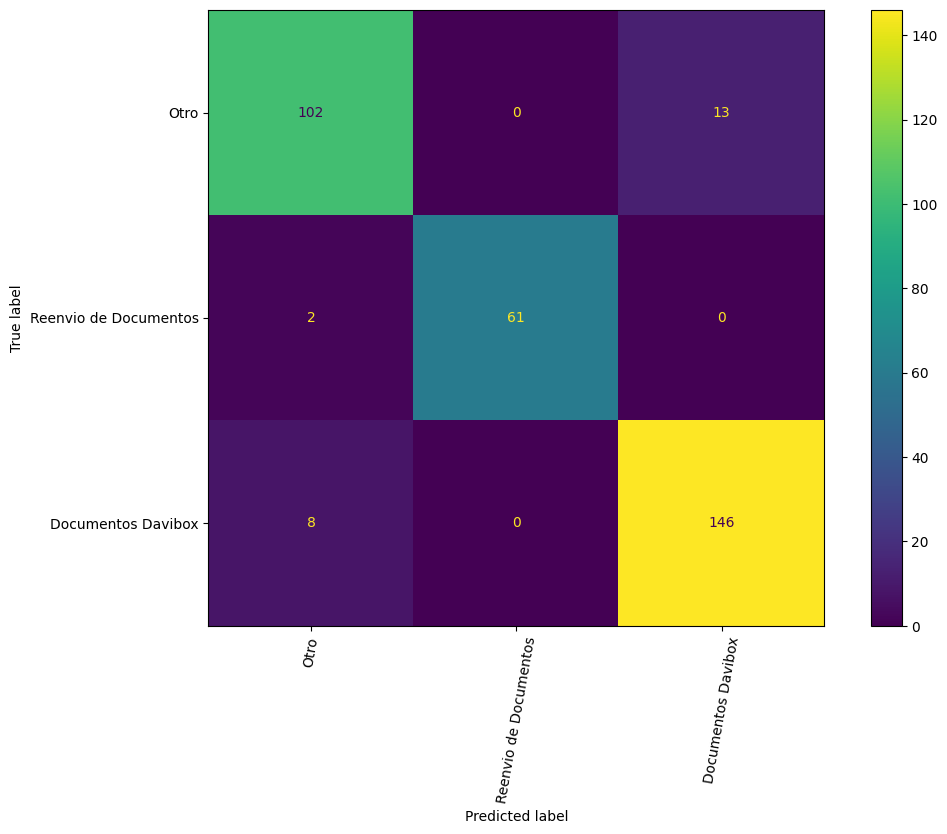

2025/05/20 11:16:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(1.0),
 np.float64(0.99),
 0.98,
 0.93,
 0.98,
 0.93,
 0.98,
 0.93,
 0.98,
 0.93]

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="yovany", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

# Modelo Multinomial Naive Bayes con GreadSearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejor Score:  0.9586342689568497
mejores hiperparametros:  {'alpha': 1}


2025/05/20 11:22:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.98
Test Accuracy:  0.93
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       0.97      0.99      0.98       348
           2       0.99      0.96      0.98       248

    accuracy                           0.98       774
   macro avg       0.99      0.99      0.99       774
weighted avg       0.98      0.98      0.98       774

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.92      0.95      0.93       154
           2       0.91      0.89      0.90       115

    accuracy                           0.93       332
   macro avg       0.94      0.93      0.94       332
weighted avg       0.93      0.93      0.93       332



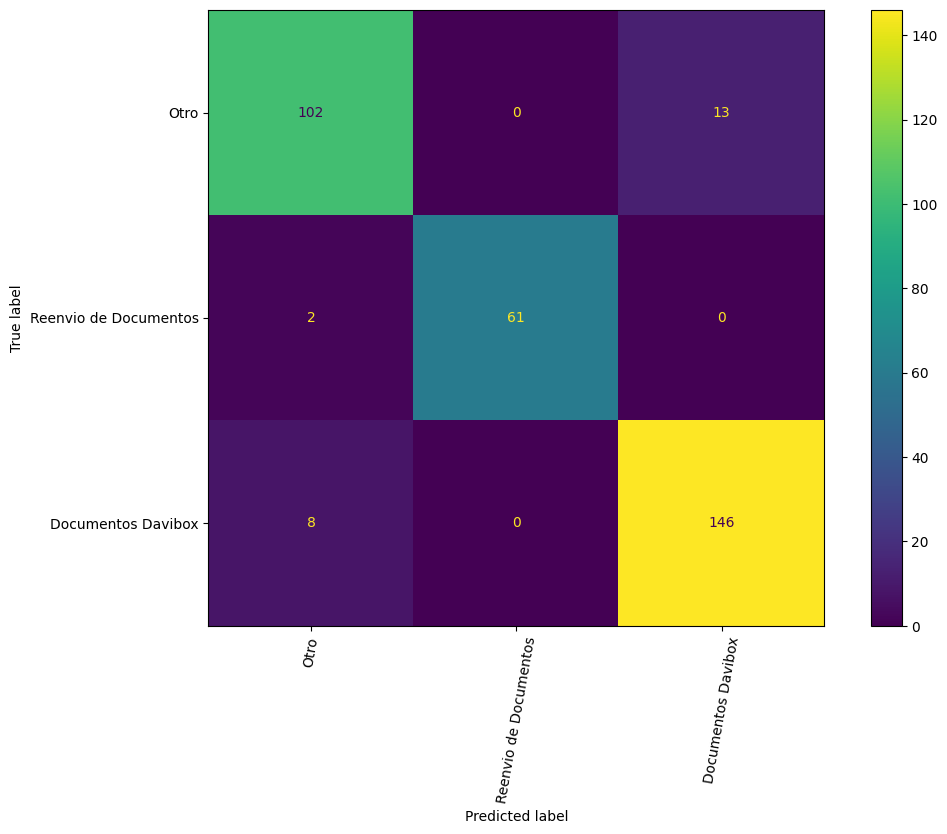

2025/05/20 11:22:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(1.0),
 np.float64(0.99),
 0.98,
 0.93,
 0.98,
 0.93,
 0.98,
 0.93,
 0.98,
 0.93]

In [ ]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring="f1_micro")
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Yovany", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

# Logistic Regression

2025/05/20 11:23:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.99
Test Accuracy:  0.97
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       178
           1       0.99      1.00      1.00       348
           2       1.00      0.99      0.99       248

    accuracy                           0.99       774
   macro avg       1.00      0.99      0.99       774
weighted avg       0.99      0.99      0.99       774

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.96      0.98      0.97       154
           2       0.96      0.95      0.95       115

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332



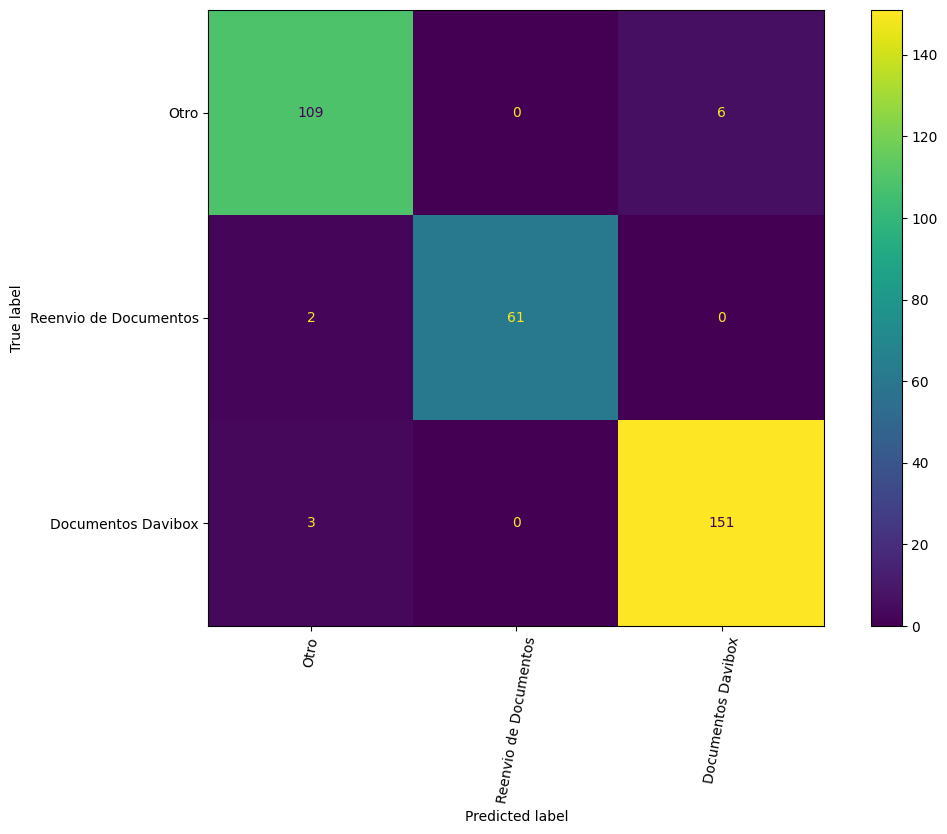

2025/05/20 11:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(1.0),
 np.float64(1.0),
 0.99,
 0.97,
 0.99,
 0.97,
 0.99,
 0.97,
 0.99,
 0.97]

In [ ]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Yovany", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

# Logistic Regression with GreadSearch

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/davinci/Desktop/tickets_clasificator/ada/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/davinci/Desktop/tickets_clasificator/ada/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/davinci/Desktop/tickets_clasificator/ada/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/davinci/Desktop/tickets_clasificator/ada/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/davinci/Desktop/tickets_clasificator/ada/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reac

Mejor Score:  0.9798905042326094
mejores hiperparametros:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


2025/05/20 11:24:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.99
Test Accuracy:  0.97
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       348
           1       0.99      0.97      0.98       348
           2       0.97      0.99      0.98       348

    accuracy                           0.99      1044
   macro avg       0.99      0.99      0.99      1044
weighted avg       0.99      0.99      0.99      1044

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.99      0.97      0.98       154
           2       0.94      0.98      0.96       115

    accuracy                           0.97       332
   macro avg       0.98      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332



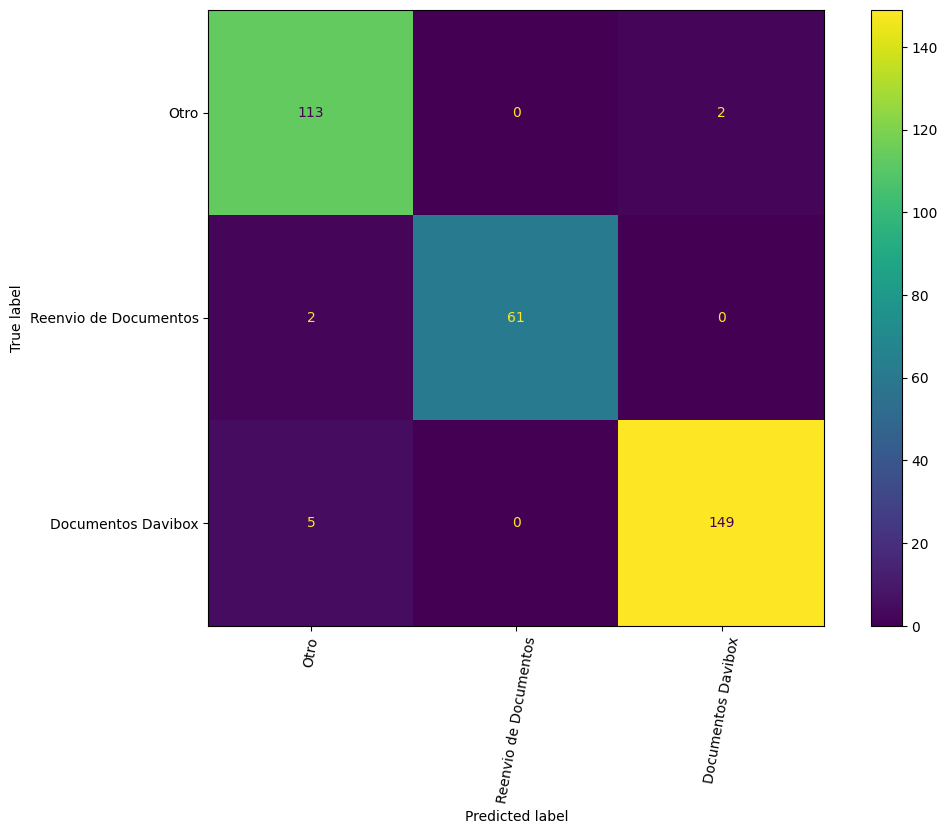

2025/05/20 11:24:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(1.0),
 np.float64(0.99),
 0.99,
 0.97,
 0.99,
 0.97,
 0.99,
 0.97,
 0.99,
 0.97]

In [38]:
# rebalance of the data
smote = SMOTE()
# transform the dataset with the SMOTE algorithm
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
# define the model with the balanced class_weight
log_reg = LogisticRegression(class_weight='balanced')

log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

grid_search_log = grid_search(log_reg, folds, log_params, scoring="f1_micro")
grid_search_log.fit(X_train_res, y_train_res)  # entrenamiento con los datos rebalanceados

print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCVSmote", 
                              developer="Yovany", 
                              X_train=X_train_res,  # evaluación con los datos rebalanceados
                              X_test=X_test, 
                              y_train=y_train_res,  # etiquetas rebalanceadas
                              y_test=y_test, 
                              use_cv=True)

# Decision Tree Classifier

2025/05/20 11:25:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  1.0
Test Accuracy:  0.9
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       348
           2       1.00      1.00      1.00       248

    accuracy                           1.00       774
   macro avg       1.00      1.00      1.00       774
weighted avg       1.00      1.00      1.00       774

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.89      0.90      0.89       154
           2       0.86      0.85      0.86       115

    accuracy                           0.90       332
   macro avg       0.91      0.91      0.91       332
weighted avg       0.90      0.90      0.90       332



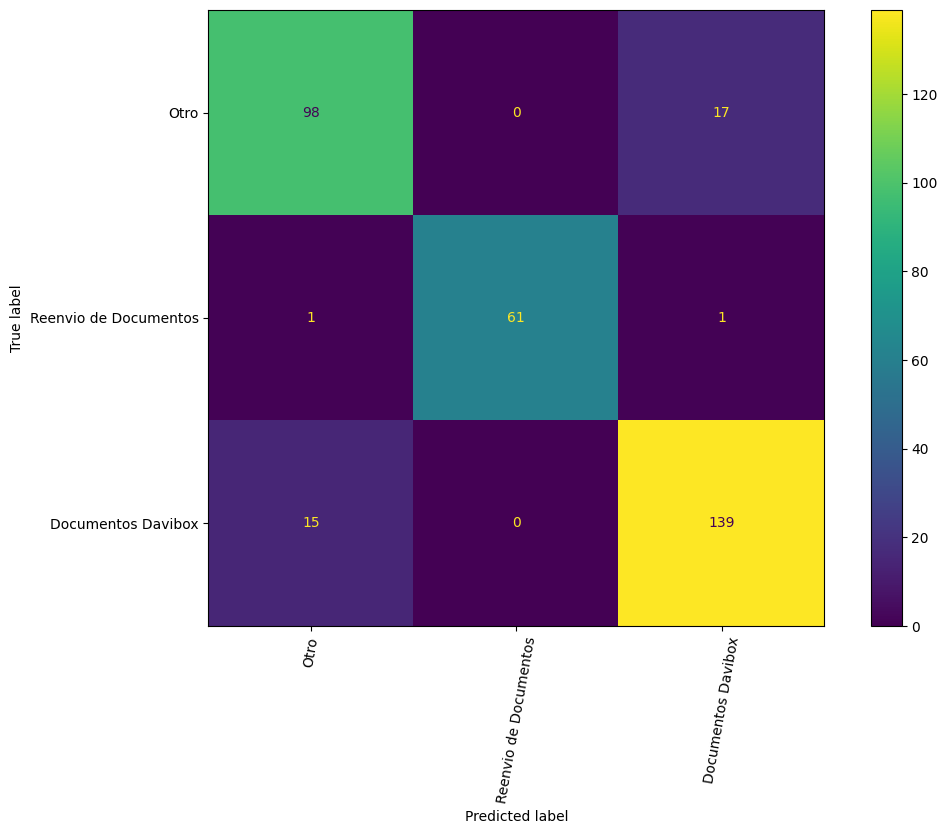

2025/05/20 11:25:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(1.0), np.float64(0.91), 1.0, 0.9, 1.0, 0.9, 1.0, 0.9, 1.0, 0.9]

In [40]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Yovany",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

# Decision Tree Classifier with Gread Search

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Mejor Score:  0.9323255722610726
mejores hiperparametros:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 7, 'splitter': 'best'}


2025/05/20 11:25:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Train Accuracy:  0.94
Test Accuracy:  0.92
Informe de clasificación del train:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       178
           1       0.97      0.89      0.93       348
           2       0.86      0.96      0.91       248

    accuracy                           0.94       774
   macro avg       0.94      0.95      0.95       774
weighted avg       0.94      0.94      0.94       774

Informe de clasificación para Test:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.94      0.88      0.91       154
           2       0.84      0.93      0.88       115

    accuracy                           0.92       332
   macro avg       0.93      0.93      0.93       332
weighted avg       0.92      0.92      0.92       332



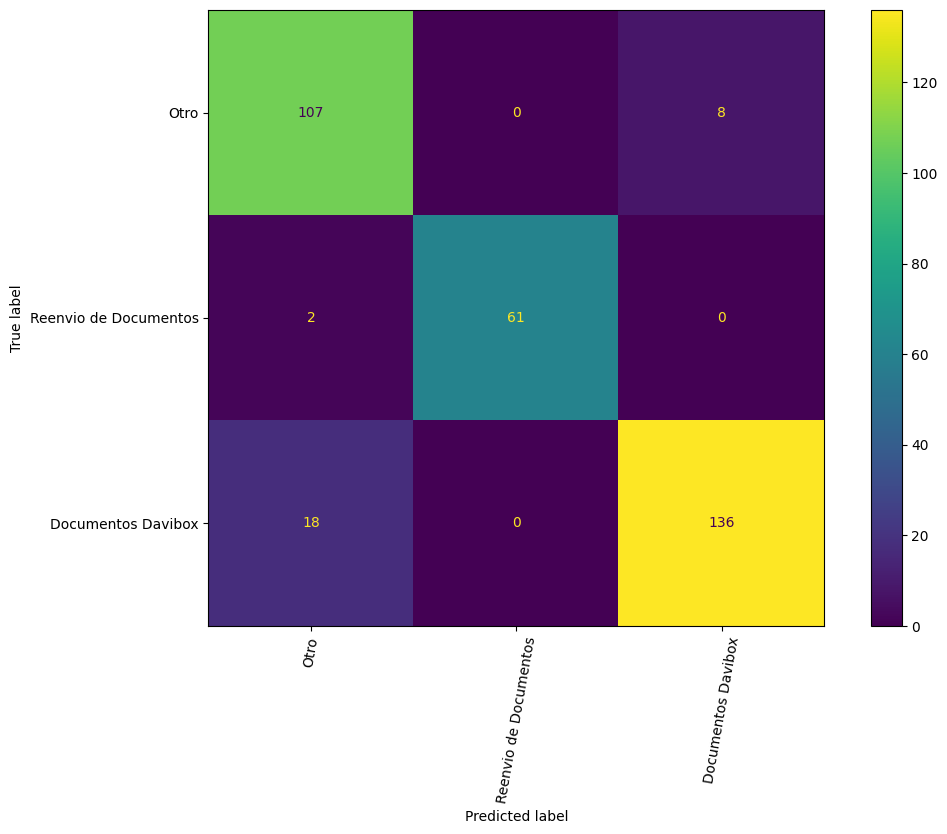

2025/05/20 11:25:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[np.float64(0.99),
 np.float64(0.96),
 0.94,
 0.92,
 0.94,
 0.92,
 0.94,
 0.92,
 0.94,
 0.92]

In [41]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2,3,4,5,6,7,8,None],
    'min_samples_leaf': [2,3,4,7],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='f1_macro')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Yovany", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)